<a href="https://colab.research.google.com/github/Tavo826/DataScience/blob/main/SpeechEmotionRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Es el intento de reconocer la emoción humana y los estados afectivos de la voz. Para esto se utiliza la librería *librosa*, que es usada para analizar audio y música. Finalmente de contruye un modelo usando MLPClassifier.

Para el conjunto de datos se usa el RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) dataset, este contiene 7356 archivos de 24 actores.

In [ ]:
!pip install soundfile

In [ ]:
import os, glob, pickle
import librosa
import soundfile
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

os.chdir('/content/drive/MyDrive/Colab Notebooks/Data Science/Reconocimiento de voz y emoción')

La función extract_feature extrae las características mfcc, chroma, y mel del archivo de audio

* **mfcc:** Mel Frequency Cepstral Coefficient, representa el espectro de potecia a corto plazo de un sonido
* **chroma:** Pertenece a las 12 classes de tonos diferentes
* **mel:** Mel Spectogram Frecuency

In [ ]:
def extract_feature(file_name, mfcc, chroma, mel):
  #with wavfile.read(file_name,) as sound_file:
  #with soundfile.SoundFile(file_name) as sound_file:
  X = wavfile.read(file_name)
  sample_rate = X[0]
  X = np.array(X[1], dtype='float32')
  #X = sound_file.read(dtype='float32')  
  if chroma:
    #Se obtiene la transformada en tiempo corto de Fourier
    stft = np.abs(librosa.stft(X))
  result = np.array([])
  #Por cada característica de las tres, se obtiene el valor medio
  if mfcc:
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfccs))
  if chroma:
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma))
  if mel:
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    
  return result

Se crea un diccionario que enumera las emociones disponibles en el dataset, y una lista con las que se requiere.

In [ ]:
#Diccionario
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

#Emociones a observar
observed_emotions = ['calm', 'happy', 'fearful', 'disgust'] 

In [ ]:
def load_data(test_size=0.2):
  x, y = [], []
  for dirpath, dirnames, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/Data Science/Reconocimiento de voz y emoción/speech-emotion-recognition-ravdess-data'):
    for file_name in filenames:
      #El tercer valor en el nombre de los archivos contiene la emoción.
      emotion = emotions[file_name.split('-')[2]]
      #Si la emoción no está entre las seleccionadas
      if emotion not in observed_emotions:
        continue
      #Se extraen las características
      feature = extract_feature(dirpath + '/' + file_name, mfcc=True, chroma=True, mel=True)
      #Se guarda la característica y la emoción
      x.append(feature)
      y.append(emotion)
  
  #Se separan los datos de entrenamiento y de prueba
  return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
x_train, x_test, y_train, y_test = load_data(test_size=0.25)

In [ ]:
print('x_train: ', x_train.shape)
print('x_test: ', x_test.shape)

x_train:  (576, 180)
x_test:  (192, 180)


MLPClassifier es un perceptrón multicapa que optimiza la función log-loss usando LBFGS o el descenso del gradiente estocástico

In [ ]:
#Inicializando MLPClassifier
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08,
                      hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
#Entrenando el modelo
model.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
#Prediciendo con el conjunto de prueba
y_pred = model.predict(x_test)
score = accuracy_score(y_test, y_pred)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False,
                          title=None, cmap=plt.cm.Blues):
  
  if not title:
    if normalize:
      title = 'Normalized confusion matrix'
    else:
      title = 'Confusion matrix, without normalization'
  
  #Calulando la matriz de confusión
  cm = confusion_matrix(y_true, y_pred)
  print(cm)
  #Solo se usan las etiquetas que aparecen en los datos
  #classes = classes[unique_labels(y_true, y_pred)]
  if normalize: cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)

  #mostrando las etiquetas
  ax.set(xticks = np.arange(cm.shape[1]),
         yticks = np.arange(cm.shape[0]),
         xticklabels = classes, yticklabels=classes, 
         title = title,
         ylabel = 'True label',
         xlabel = 'Predicted label')
  
  #rotando los ejes
  plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
           rotation_mode='anchor')
  
  #Se recorren las dimensiones de los datos y se crean las anotaciones
  fmt = '.1f' if normalize else 'd'
  thresh = cm.max() / 2
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i,j], fmt),
              ha='center', va='center',
              color='white' if cm[i,j] > thresh else 'black')
  fig.tight_layout()
  return ax

[[35  5  2  9]
 [ 2 20 10 14]
 [ 6  5 21 16]
 [ 1  8 14 24]]
              precision    recall  f1-score   support

        calm       0.80      0.69      0.74        51
       happy       0.53      0.43      0.48        46
     fearful       0.45      0.44      0.44        48
     disgust       0.38      0.51      0.44        47

    accuracy                           0.52       192
   macro avg       0.54      0.52      0.52       192
weighted avg       0.54      0.52      0.53       192



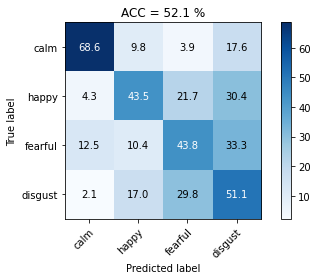

In [ ]:
plot_confusion_matrix(y_test, y_pred,
                      classes = observed_emotions,
                      normalize=True,
                      title='ACC = %.1f %%' % (100*score))

cr = classification_report(y_test, y_pred,
                           target_names = observed_emotions)

print(cr)